The implementation of the model utilizes Cornac, a comprehensive framework designed for recommender systems. Cornac emphasizes models that leverage auxiliary data, such as item descriptive text, images, and social network information, to enhance recommendation performance.

In [221]:
# importing required libraries
import os
import sys
import cornac
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import map, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED
from recommenders.utils.notebook_utils import store_metadata

In [223]:
data_size = '100k'
data = movielens.load_pandas_df(size=data_size, header=["userID", "itemID", "rating"])
train, test = python_random_split(data, 0.75)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.81k/4.81k [00:00<00:00, 10.7kKB/s]


In [225]:
data.shape

(100000, 3)

In [227]:
# EDA: Basic statistics and visualizations
print(data.describe())

             userID         itemID         rating
count  100000.00000  100000.000000  100000.000000
mean      462.48475     425.530130       3.529860
std       266.61442     330.798356       1.125674
min         1.00000       1.000000       1.000000
25%       254.00000     175.000000       3.000000
50%       447.00000     322.000000       4.000000
75%       682.00000     631.000000       4.000000
max       943.00000    1682.000000       5.000000


In [229]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   userID  100000 non-null  int64  
 1   itemID  100000 non-null  int64  
 2   rating  100000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB
None


/var/folders/9g/zqf1mnsx4zn9j67nwgv0m6jh0000gn/T/ipykernel_36283/1020770905.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=data, palette='viridis')


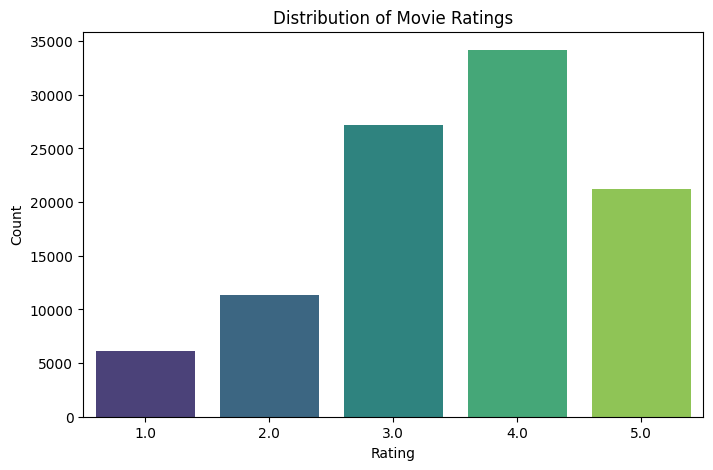

In [231]:
# Distribution of ratings
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=data, palette='viridis')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

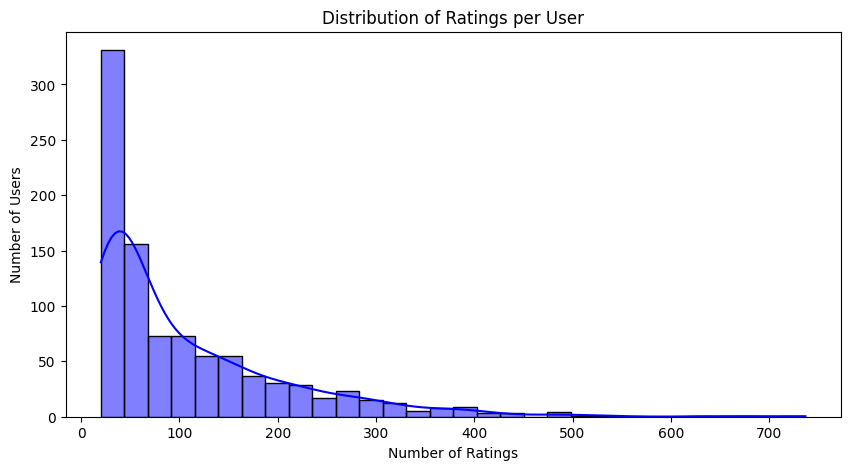

In [233]:
# Distribution of number of ratings per user
user_counts = data['userID'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(user_counts, bins=30, kde=True, color='blue')
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

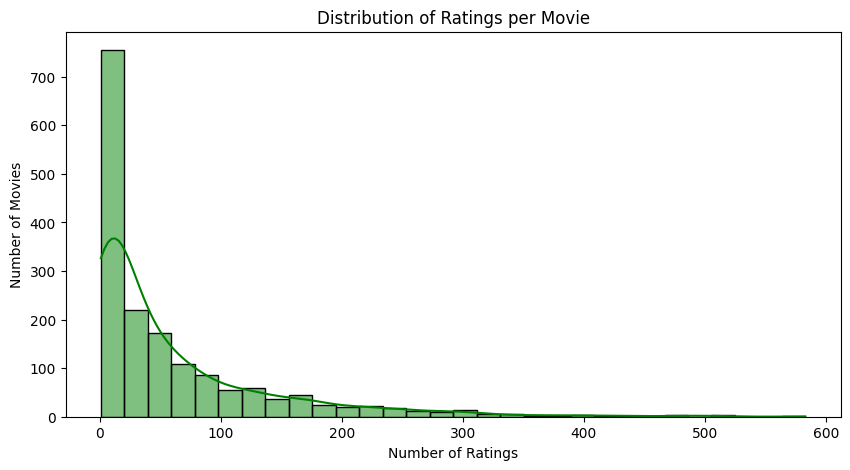

In [235]:
# Distribution of number of ratings per movie
item_counts = data['itemID'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(item_counts, bins=30, kde=True, color='green')
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

In [237]:
# Splitting data into training and testing sets (75% training, 25% testing)
train, test = python_random_split(data, 0.75)

To work with models implemented in Cornac, it is essential to construct an object from the Dataset class.

The Dataset class in Cornac serves as the primary object with which the models interact. In addition to facilitating data transformations, the Dataset class provides a variety of useful iterators for iterating through the data, as well as support for various negative sampling techniques.

In [239]:
# Create Cornac Dataset
train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)

The BPR (Bayesian Personalized Ranking) model includes several important parameters that should be considered:

k: This parameter controls the dimensionality of the latent space, which corresponds to the size of the latent vectors.
max_iter: This parameter defines the number of iterations for the Stochastic Gradient Descent (SGD) procedure.
learning_rate: This parameter regulates the step size in the gradient update rules.
lambda_reg: This parameter governs the L2 regularization in the objective function.


In [241]:
bpr = cornac.models.BPR(
    max_iter=200,
    learning_rate=0.01,
    lambda_reg=0.005,
    verbose=True,
    seed=SEED
)

with Timer() as t:
    bpr.fit(train_set)
print("Took {} seconds for training.".format(t))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 186.92it/s, correct=93.57%, skipped=9.30%]

Optimization finished!
Took 1.0797 seconds for training.


In [243]:
with Timer() as t:
    all_predictions = predict_ranking(bpr, train, usercol='userID', itemcol='itemID', remove_seen=True)
print("Took {} seconds for prediction.".format(t))
print("Shape of all predictions: \n",all_predictions.shape)
print("head of all_predictions -\n \n", all_predictions.head())

Took 0.7815 seconds for prediction.
Shape of all predictions: 
 (1473406, 3)
head of all_predictions -
 
    userID  itemID  prediction
0       1       1    4.287233
3       1       4    2.420812
5       1       6   -0.662344
7       1       8    3.154591
9       1      10    1.926674


In [245]:
k = 10
#Mean Average Precision (MAP) 
eval_map = map(test, all_predictions, col_prediction='prediction', k=k)
#Normalized Discounted Cumulative Gain
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=k)
#precision_at_k
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
# recall_at_k
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

/Users/siddharthach/.pyenv/versions/lightfm-env/lib/python3.9/site-packages/recommenders/evaluation/python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
/Users/siddharthach/.pyenv/versions/lightfm-env/lib/python3.9/site-packages/recommenders/evaluation/python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


MAP:	0.118449
NDCG:	0.417502
Precision@K:	0.371762
Recall@K:	0.200258


In [247]:
model=bpr
# Getting the user-item pairs from the test set
test_users = test['userID'].unique()  # Replace with your actual user ID column
top_n = 10  # Number of recommendations

# Generating recommendations for each user
for user in test_users:
    recommended_items = model.recommend(user, k=top_n)
    print(f"Top {10} recommendations for user {user}: {recommended_items}")

Top 10 recommendations for user 877: [70, 216, 83, 382, 173, 22, 56, 172, 204, 191]
Top 10 recommendations for user 815: [174, 135, 172, 496, 168, 22, 82, 204, 98, 216]
Top 10 recommendations for user 94: [56, 234, 98, 12, 53, 423, 4, 77, 144, 182]
Top 10 recommendations for user 416: [258, 692, 423, 283, 588, 300, 237, 173, 742, 44]
Top 10 recommendations for user 500: [275, 13, 382, 15, 475, 1, 70, 238, 25, 237]
Top 10 recommendations for user 259: [100, 7, 50, 56, 121, 181, 127, 12, 98, 288]
Top 10 recommendations for user 598: [300, 313, 258, 269, 328, 301, 271, 690, 323, 294]
Top 10 recommendations for user 886: [56, 156, 42, 12, 433, 33, 182, 475, 4, 144]
Top 10 recommendations for user 837: [111, 237, 15, 275, 25, 257, 255, 125, 274, 476]
Top 10 recommendations for user 521: [144, 195, 210, 117, 56, 121, 181, 7, 50, 174]
Top 10 recommendations for user 459: [405, 294, 471, 121, 1, 117, 257, 181, 237, 15]
Top 10 recommendations for user 622: [168, 393, 210, 202, 173, 56, 451, 144

In [249]:
bpr = cornac.models.BPR(
    max_iter=500,
    learning_rate=0.01,
    lambda_reg=0.005,
    verbose=True,
    seed=SEED
)

with Timer() as t:
    bpr.fit(train_set)
print("Took {} seconds for training.".format(t))

print("*"*80)

with Timer() as t:
    all_predictions = predict_ranking(bpr, train, usercol='userID', itemcol='itemID', remove_seen=True)
print("Took {} seconds for prediction.".format(t))
print("Shape of all predictions: \n",all_predictions.shape)
print("head of all_predictions -\n \n", all_predictions.head())

print("*"*80)
k = 10
#Mean Average Precision (MAP) 
eval_map = map(test, all_predictions, col_prediction='prediction', k=k)
#Normalized Discounted Cumulative Gain
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=k)
#precision_at_k
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
# recall_at_k
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')
print("*"*80)
model=bpr
# Getting the user-item pairs from the test set
test_users = test['userID'].unique()  # Replace with your actual user ID column
top_n = 10  # Number of recommendations

# Generating recommendations for each user
for user in test_users:
    recommended_items = model.recommend(user, k=top_n)
    print(f"Top {10} recommendations for user {user}: {recommended_items}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 190.28it/s, correct=93.76%, skipped=9.30%]


Optimization finished!
Took 2.6314 seconds for training.
********************************************************************************
Took 0.7100 seconds for prediction.
Shape of all predictions: 
 (1473406, 3)
head of all_predictions -
 
    userID  itemID  prediction
0       1       1    4.011580
3       1       4    2.015678
5       1       6   -0.554928
7       1       8    2.752969
9       1      10    2.112159
********************************************************************************


/Users/siddharthach/.pyenv/versions/lightfm-env/lib/python3.9/site-packages/recommenders/evaluation/python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
/Users/siddharthach/.pyenv/versions/lightfm-env/lib/python3.9/site-packages/recommenders/evaluation/python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


MAP:	0.121182
NDCG:	0.420524
Precision@K:	0.369639
Recall@K:	0.200884
********************************************************************************
Top 10 recommendations for user 877: [83, 258, 286, 269, 275, 70, 306, 22, 313, 707]
Top 10 recommendations for user 815: [172, 135, 132, 419, 204, 174, 98, 89, 97, 423]
Top 10 recommendations for user 94: [56, 98, 234, 77, 655, 204, 568, 4, 403, 53]
Top 10 recommendations for user 416: [288, 237, 173, 66, 69, 655, 282, 742, 591, 393]
Top 10 recommendations for user 500: [275, 15, 70, 237, 116, 111, 949, 283, 25, 83]
Top 10 recommendations for user 259: [7, 100, 50, 288, 117, 56, 121, 475, 127, 181]
Top 10 recommendations for user 598: [271, 313, 300, 258, 751, 328, 690, 270, 343, 748]
Top 10 recommendations for user 886: [56, 42, 92, 156, 12, 475, 4, 100, 144, 182]
Top 10 recommendations for user 837: [111, 237, 15, 25, 274, 476, 118, 121, 405, 275]
Top 10 recommendations for user 521: [210, 56, 117, 144, 7, 195, 174, 50, 121, 173]
Top 

In [251]:
bpr = cornac.models.BPR(
    max_iter=10000,
    learning_rate=0.01,
    lambda_reg=0.005,
    verbose=True,
    seed=SEED
)

with Timer() as t:
    bpr.fit(train_set)
print("Took {} seconds for training.".format(t))

print("*"*80)

with Timer() as t:
    all_predictions = predict_ranking(bpr, train, usercol='userID', itemcol='itemID', remove_seen=True)
print("Took {} seconds for prediction.".format(t))
print("Shape of all predictions: \n",all_predictions.shape)
print("head of all_predictions -\n \n", all_predictions.head())

print("*"*80)
k = 10
#Mean Average Precision (MAP) 
eval_map = map(test, all_predictions, col_prediction='prediction', k=k)
#Normalized Discounted Cumulative Gain
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=k)
#precision_at_k
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
# recall_at_k
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')
print("*"*80)
model=bpr
# Getting the user-item pairs from the test set
test_users = test['userID'].unique()  # Replace with your actual user ID column
top_n = 10  # Number of recommendations

# Generating recommendations for each user
for user in test_users:
    recommended_items = model.recommend(user, k=top_n)
    print(f"Top {10} recommendations for user {user}: {recommended_items}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:52<00:00, 189.46it/s, correct=93.86%, skipped=9.28%]


Optimization finished!
Took 52.7850 seconds for training.
********************************************************************************
Took 0.7771 seconds for prediction.
Shape of all predictions: 
 (1473406, 3)
head of all_predictions -
 
    userID  itemID  prediction
0       1       1    3.611709
3       1       4    1.880110
5       1       6   -1.256530
7       1       8    3.195097
9       1      10    1.873625
********************************************************************************


/Users/siddharthach/.pyenv/versions/lightfm-env/lib/python3.9/site-packages/recommenders/evaluation/python_evaluation.py:438: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
/Users/siddharthach/.pyenv/versions/lightfm-env/lib/python3.9/site-packages/recommenders/evaluation/python_evaluation.py:439: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  rating_true_common.groupby(col_user, as_index=False)[col_user].agg(


MAP:	0.121347
NDCG:	0.424716
Precision@K:	0.375690
Recall@K:	0.201783
********************************************************************************
Top 10 recommendations for user 877: [83, 213, 582, 313, 286, 70, 86, 707, 660, 747]
Top 10 recommendations for user 815: [135, 174, 419, 496, 181, 172, 423, 432, 98, 132]
Top 10 recommendations for user 94: [56, 173, 98, 12, 204, 176, 4, 64, 168, 69]
Top 10 recommendations for user 416: [88, 393, 294, 216, 237, 288, 781, 313, 300, 411]
Top 10 recommendations for user 500: [582, 213, 275, 14, 50, 121, 70, 283, 83, 88]
Top 10 recommendations for user 259: [288, 50, 7, 100, 475, 56, 127, 98, 174, 181]
Top 10 recommendations for user 598: [271, 751, 258, 313, 690, 326, 748, 300, 259, 270]
Top 10 recommendations for user 886: [4, 56, 12, 42, 273, 168, 92, 182, 33, 367]
Top 10 recommendations for user 837: [111, 275, 15, 125, 283, 274, 476, 121, 405, 237]
Top 10 recommendations for user 521: [50, 181, 174, 56, 7, 176, 172, 173, 168, 117]
Top 

In [253]:
!pip freeze > requirements.txt